In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config) 

In [3]:

from sklearn.model_selection import train_test_split
import numpy as np


path = '/content/drive/MyDrive/Final project/'
images = np.load(path + 'images_256.npy')
masks = np.load(path + 'masks_256.npy')

images = images[..., np.newaxis]
masks = masks[..., np.newaxis]

for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.mean(images[i,:, :]))/ np.std(images[i,:, :])


images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=1)


print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))

print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

Images_train shape: (2451, 256, 256, 1)
Masks_train shape: (2451, 256, 256, 1)
Images_test shape: (613, 256, 256, 1)
Masks_test shape: (613, 256, 256, 1)


In [4]:
# import tensorflow as tf

# batch_size = 8
# AUTOTUNE = tf.data.AUTOTUNE

# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds


# train_ds = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
# train_ds = configure_for_performance(train_ds)

# test_ds = tf.data.Dataset.from_tensor_slices((images_test, masks_test)) 
# test_ds = configure_for_performance(test_ds)

### Model

In [4]:

from __future__ import absolute_import

import warnings
import numpy as np
import tensorflow as tf
from tensorflow import math
import tensorflow.keras.backend as K
from tensorflow.nn import depth_to_space
from tensorflow.image import extract_patches
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Embedding, Dropout, Conv2D, BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax



In [5]:

def conv_layer(X, 
               filters, 
               kernel_size=1, 
               activation='Softmax', 
               layer_name='conv_output'):

    x = Conv2D(filters, kernel_size, padding='same', use_bias=True, name=layer_name)(X)
    if activation:
        if activation == 'Sigmoid':
            x = Activation('sigmoid', name='{}_activation'.format(layer_name))(x)
        else:
            activation_func = eval(activation)
            x = activation_func(name='{}_activation'.format(layer_name))(x)   
    return x

In [6]:

class extract_patch(Layer):
    def __init__(self, 
                 patch_size, 
                 **kwargs):
      
        super(extract_patch, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.patch_size_dim = patch_size[0]
    
    def call(self, images):
        
        batch_size = tf.shape(images)[0]
        patches = extract_patches(images=images, sizes=(1, self.patch_size_dim, self.patch_size_dim, 1), strides=(1, self.patch_size_dim, self.patch_size_dim, 1), rates=(1, 1, 1, 1), padding='VALID',)
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        patches = tf.reshape(patches, (batch_size, patch_num*patch_num, patch_dim))
        return patches
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({'patch_size': self.patch_size,})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    

In [7]:

class embed_patch(Layer):
    def __init__(self, 
                 num_patches, 
                 embed_dim, 
                 **kwargs):
        
        super(embed_patch, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.projection = Dense(embed_dim)
        self.position_embed = Embedding(input_dim=num_patches, output_dim=embed_dim)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'embed_dim': self.embed_dim,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patches, delta=1)
        embed = self.projection(patch) + self.position_embed(pos)
        return embed

In [8]:

class merge_patch(Layer):
    def __init__(self, 
                 num_patches, 
                 embed_dim, 
                 name='', 
                 **kwargs):
      
        super(merge_patch, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.linear = Dense(2*embed_dim, use_bias=False, name='{}_linear_trans'.format(name))

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'embed_dim': self.embed_dim,
            'name':self.name})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x):
        
        H, W = self.num_patches
        B, L, C = x.get_shape().as_list()
        assert (L == H * W), 'input dimensions do not match'
        assert (H % 2 == 0 and W % 2 == 0), '{}-by-{} patches received, they must be even number'.format(H, W)
        x = tf.reshape(x, shape=(-1, H, W, C))
        x0 = x[:, 0::2, 0::2, :]  
        x1 = x[:, 1::2, 0::2, :] 
        x2 = x[:, 0::2, 1::2, :]  
        x3 = x[:, 1::2, 1::2, :]  
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (H//2)*(W//2), 4*C))
        x = self.linear(x)
        return x

In [9]:

class expand_patch(Layer):
    def __init__(self, 
                 num_patches, 
                 embed_dim, 
                 upsample_rate, 
                 return_vector=True, 
                 name='patch_expand', 
                 **kwargs):
        
        super(expand_patch, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.upsample_rate = upsample_rate
        self.return_vector = return_vector
        self.linear = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        # self.linear_trans2 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        self.prefix = name
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'embed_dim': self.embed_dim,
            'upsample_rate': self.upsample_rate,
            'return_vector': self.return_vector,
            'name':self.prefix})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x):
        
        H, W = self.num_patches
        B, L, C = x.get_shape().as_list()
        assert (L == H * W), 'input dimension do not match'
        x = tf.reshape(x, (-1, H, W, C))
        x = self.linear(x)
        x = depth_to_space(x, self.upsample_rate, data_format='NHWC', name='{}_d_to_space'.format(self.prefix))
        if self.return_vector:
            x = tf.reshape(x, (-1, L*self.upsample_rate*self.upsample_rate, C//2))
        return x

In [10]:

def window_part(x, 
                window_size):
    
    _, H, W, C = x.get_shape().as_list()
    patch_H = H//window_size
    patch_W = W//window_size
    x = tf.reshape(x, shape=(-1, patch_H, window_size, patch_W, window_size, C))
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    window_partitions = tf.reshape(x, shape=(-1, window_size, window_size, C))
    return window_partitions


def window_reverse(windows, 
                   window_size, 
                   H, 
                   W, 
                   C):
    
    patch_H = H//window_size
    patch_W = W//window_size
    x = tf.reshape(windows, shape=(-1, patch_H, patch_W, window_size, window_size, C))
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, H, W, C))
    return x

In [11]:

def drop_path_(inputs, 
               drop_probability, 
               is_training):
    
    if (not is_training) or (drop_probability == 0.):
        return inputs
    keep_probability = 1.0 - drop_probability

    input_shape = tf.shape(inputs)
    batch_num = input_shape[0]
    rank = len(input_shape)
    shape = (batch_num,) + (1,) * (rank - 1)
    random_tensor = keep_probability + tf.random.uniform(shape, dtype=inputs.dtype)
    path_mask = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_probability) * path_mask
    return output


class drop_path(Layer):
    def __init__(self, 
                 drop_probability=None, 
                 **kwargs):
        super(drop_path, self).__init__(**kwargs)
        self.drop_probability = drop_probability

    def get_config(self):
        config = super().get_config().copy()
        config.update({'drop_probability': self.drop_probability})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x, training=None):
        return drop_path_(x, self.drop_probability, training)


In [12]:

class Mlp(Layer):
    def __init__(self, 
                 filter_num, 
                 dropout=0., 
                 name='mlp', 
                 **kwargs):
        
        super(Mlp, self).__init__(**kwargs)
        self.filter_num = filter_num
        self.drop = dropout
        self.fc1 = Dense(filter_num[0], name='{}_mlp_0'.format(name))
        self.fc2 = Dense(filter_num[1], name='{}_mlp_1'.format(name))
        self.drop = Dropout(dropout)
        self.activation = tf.keras.activations.gelu
        self.prefix = name
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filter_num': self.filter_num,
            'drop': self.drop,
            'name': self.prefix})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [13]:
class Window_Attention(Layer):
    def __init__(self, 
                 dim, 
                 window_size, 
                 num_heads, 
                 qkv_bias=True, 
                 qk_scale=None, 
                 attn_drop=0, 
                 proj_drop=0., 
                 name='swin_atten', 
                 **kwargs):
      
        super(Window_Attention, self).__init__(**kwargs)
        self.dim = dim 
        self.window_size = window_size 
        self.num_heads = num_heads 
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5 
        self.prefix_name = name
        
        self.qkv = Dense(dim * 3, use_bias=qkv_bias, name='{}_attn_qkv'.format(self.prefix_name))
        self.attn_drop = Dropout(attn_drop)
        self.linear = Dense(dim, name='{}_attn_proj'.format(self.prefix_name))
        self.proj_drop = Dropout(proj_drop)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'dim':self.dim, 
            'window_size':self.window_size, 
            'num_heads':self.num_heads, 
            'qkv_bias':self.qkv_bias, 
            'qk_scale':self.qk_scale, 
            'attn_drop':self.attn_drop, 
            'proj_drop':self.proj_drop, 
            'name':self.prefix_name})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
    def build(self, input_shape):
        number_window_elements = (2*self.window_size[0] - 1) * (2*self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight('{}_attn_pos'.format(self.prefix_name),
                                                            shape=(number_window_elements, self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing='ij')
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(relative_position_index), 
                                                   trainable=False, 
                                                   name='{}_attn_pos_ind'.format(self.prefix_name))
        self.built = True

    def call(self, x, mask=None):
        _, N, C = x.get_shape().as_list()
        head_dim = C//self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = (q @ k)
        
        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape=(-1,))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias, shape=(num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=(-1, nW, self.num_heads, N, N)) + mask_float
            attn = tf.reshape(attn, shape=(-1, self.num_heads, N, N))
            attn = softmax(attn, axis=-1)
        else:
            attn = softmax(attn, axis=-1)
        attn = self.attn_drop(attn)
        x_qkv = (attn @ v)
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, C))
        x_qkv = self.linear(x_qkv)
        x_qkv = self.proj_drop(x_qkv)
        return x_qkv


In [14]:

class SwinBlock(Layer):
    def __init__(self, 
                 dim, 
                 num_patch, 
                 num_heads, 
                 window_size=7, 
                 shift_size=0, 
                 num_mlp=1024, 
                 qkv_bias=True, 
                 qk_scale=None, 
                 mlp_drop=0, 
                 attn_drop=0, 
                 proj_drop=0, 
                 drop_path_prob=0, 
                 name='swin_block', 
                 **kwargs):
        
        super(SwinBlock, self).__init__(**kwargs)
        self.dim = dim 
        self.num_patch = num_patch 
        self.num_heads = num_heads 
        self.window_size = window_size 
        self.shift_size = shift_size 
        self.num_mlp = num_mlp 
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.mlp_drop = mlp_drop
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop
        self.drop_path_prob = drop_path_prob
        self.prefix = name
        
        self.norm1 = LayerNormalization(epsilon=1e-5, 
                                        name='{}_norm1'.format(self.prefix))
        self.attn = Window_Attention(dim, 
                                     window_size=(self.window_size, self.window_size), 
                                     num_heads=num_heads,
                                     qkv_bias=qkv_bias, 
                                     qk_scale=qk_scale, 
                                     attn_drop=attn_drop, 
                                     proj_drop=proj_drop, 
                                     name=self.prefix)
        
        self.drop_path = drop_path(drop_path_prob)
        self.norm2 = LayerNormalization(epsilon=1e-5, 
                                        name='{}_norm2'.format(self.prefix))
        self.mlp = Mlp([num_mlp, dim], 
                       dropout=mlp_drop, 
                       name=self.prefix)
        
        
        assert 0 <= self.shift_size, 'shift_size >= 0 is required'
        assert self.shift_size < self.window_size, 'shift_size < window_size is required'
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'dim':self.dim, 
            'num_patch':self.num_patch, 
            'num_heads':self.num_heads, 
            'window_size':self.window_size, 
            'shift_size':self.shift_size, 
            'num_mlp':self.num_mlp,
            'qkv_bias':self.qkv_bias, 
            'qk_scale':self.qk_scale, 
            'mlp_drop':self.mlp_drop, 
            'attn_drop':self.attn_drop, 
            'proj_drop':self.proj_drop, 
            'drop_path_prob':self.drop_path_prob, 
            'name':self.prefix})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.num_patch
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            mask_array = np.zeros((1, H, W, 1))
            
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)
            mask_windows = window_part(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False, name='{}_attn_mask'.format(self.prefix))
        else:
            self.attn_mask = None
        self.built = True

    def call(self, x):
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        assert L == H * W, 'No of Patches do not match'
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, H, W, C))
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x
        x_windows = window_part(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, C))
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = tf.reshape(attn_windows, shape=(-1, self.window_size, self.window_size, C))
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
            
        x = tf.reshape(x, shape=(-1, H*W, C))
        x = self.drop_path(x)
        x = x_skip +  x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


In [15]:

def swin_stack(X, 
               stack_num,
               embed_dim, 
               num_patch, 
               num_heads, 
               window_size, 
               num_mlp, 
               shift_window=True, 
               name=''):

    mlp_drop_rate = 0 
    attn_drop_rate = 0 
    proj_drop_rate = 0 
    drop_path_rate = 0 
    qkv_bias = True 
    qk_scale = None 
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size
        
        X = SwinBlock(dim=embed_dim, 
                      num_patch=num_patch, 
                      num_heads=num_heads, 
                      window_size=window_size, 
                      shift_size=shift_size_temp, 
                      num_mlp=num_mlp, 
                      qkv_bias=qkv_bias, 
                      qk_scale=qk_scale,
                      mlp_drop=mlp_drop_rate, 
                      attn_drop=attn_drop_rate, 
                      proj_drop=proj_drop_rate, 
                      drop_path_prob=drop_path_rate, 
                      name='name{}'.format(i))(X)
    return X

In [16]:

def swin_unet_base(input_tensor, 
                   filter_num_begin, 
                   depth, 
                   stack_num_down, 
                   stack_num_up, 
                   patch_size, 
                   num_heads, 
                   window_size, 
                   num_mlp, 
                   shift_window=True, 
                   name='swin_unet'):
    
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    embed_dim = filter_num_begin
    depth_ = depth
    X_skip = []
    X = input_tensor
    X = extract_patch(patch_size)(X)
    X = embed_patch(num_patch_x*num_patch_y, embed_dim)(X)
    X = swin_stack(X, 
                   stack_num=stack_num_down, 
                   embed_dim=embed_dim, 
                   num_patch=(num_patch_x, num_patch_y), 
                   num_heads=num_heads[0], 
                   window_size=window_size[0], 
                   num_mlp=num_mlp, 
                   shift_window=shift_window, 
                   name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    for i in range(depth_-1):
        X = merge_patch((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        X = swin_stack(X, 
                       stack_num=stack_num_down, 
                       embed_dim=embed_dim, 
                       num_patch=(num_patch_x, num_patch_y), 
                       num_heads=num_heads[i+1], 
                       window_size=window_size[i+1], 
                       num_mlp=num_mlp, 
                       shift_window=shift_window, 
                       name='{}_swin_down{}'.format(name, i+1))
        
        X_skip.append(X)
        
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    X = X_skip[0]
    X_decode = X_skip[1:]
    depth_decode = len(X_decode)

    for i in range(depth_decode):
        X = expand_patch(num_patches=(num_patch_x, num_patch_y),
                         embed_dim=embed_dim, 
                         upsample_rate=2, 
                         return_vector=True, 
                         name='{}_swin_up{}'.format(name, i))(X)
        
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, 
                  use_bias=False, 
                  name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        X = swin_stack(X, 
                       stack_num=stack_num_up, 
                       embed_dim=embed_dim, 
                       num_patch=(num_patch_x, num_patch_y), 
                       num_heads=num_heads[i], 
                       window_size=window_size[i], 
                       num_mlp=num_mlp, 
                       shift_window=shift_window, 
                       name='{}_swin_up{}'.format(name, i))
        
    X = expand_patch(num_patches=(num_patch_x, num_patch_y),
                     embed_dim=embed_dim, 
                     upsample_rate=patch_size[0], 
                     return_vector=False)(X)
    return X


def swin_unet_2d(input_size, 
                 filter_num_begin, 
                 n_labels, 
                 depth, 
                 stack_num_down, 
                 stack_num_up, 
                 patch_size, 
                 num_heads, 
                 window_size, 
                 num_mlp, 
                 output_activation='Softmax', 
                 shift_window=True, 
                 name='swin_unet'):
    
    IN = Input(input_size)  
    X = swin_unet_base(IN, 
                          filter_num_begin=filter_num_begin, 
                          depth=depth, 
                          stack_num_down=stack_num_down, 
                          stack_num_up=stack_num_up, 
                          patch_size=patch_size, 
                          num_heads=num_heads, 
                          window_size=window_size, 
                          num_mlp=num_mlp, 
                          shift_window=True, 
                          name=name)
    
    OUT = conv_layer(X, 
                     n_labels, 
                     kernel_size=1, 
                     activation=output_activation, 
                     layer_name='{}_output'.format(name))
    
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))
    return model

In [17]:
model = swin_unet_2d((256, 256, 1), 
                     filter_num_begin=64, 
                     n_labels=1, 
                     depth=4, 
                     stack_num_down=2, 
                     stack_num_up=2, 
                     patch_size=(2, 2), 
                     num_heads=[4, 8, 8, 8], 
                     window_size=[4, 2, 2, 2], 
                     num_mlp=512, 
                     output_activation='Sigmoid', 
                     shift_window=True, 
                     name='swin_unet')

model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 extract_patch (extract_patch)  (None, 16384, 4)     0           ['input_1[0][0]']                
                                                                                                  
 embed_patch (embed_patch)      (None, 16384, 64)    1048896     ['extract_patch[0][0]']          
                                                                                                  
 swin_block (SwinBlock)         (None, 16384, 64)    83460       ['embed_patch[0][0]

In [18]:
from tensorflow.keras.losses import binary_crossentropy

smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              loss = 'binary_crossentropy', 
              metrics=[dice_coef]) 

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# model checkpoint callback
model_weights_saving_path = "/content/drive/MyDrive/Final project/Revised_SwinUnet.h5"
checkpoint = ModelCheckpoint(model_weights_saving_path, 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor = 'dice_coef', 
                             mode='max')

# learning rate scheduling callback
lr = ReduceLROnPlateau(factor=0.3, 
                       patience=3, 
                       verbose=1, 
                       monitor = 'val_dice_coef')

# early stopping after 7 epochs
stop = EarlyStopping(patience=7, monitor='dice_coef', mode='max', verbose=1)

history = model.fit(images_train, masks_train, 
                    epochs = 10, 
                    batch_size = 2,
                    callbacks = [checkpoint, lr, stop], 
                    validation_data = (images_test, masks_test)) 

Epoch 1/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0600 - dice_coef: 0.1575
Epoch 1: dice_coef improved from -inf to 0.15750, saving model to /content/drive/MyDrive/Final project/Revised_SwinUnet.h5
1226/1226 [==============================] - 9387s 8s/step - loss: 0.0600 - dice_coef: 0.1575 - val_loss: 0.0588 - val_dice_coef: 0.1702 - lr: 1.0000e-04
Epoch 2/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0471 - dice_coef: 0.2662
Epoch 2: dice_coef improved from 0.15750 to 0.26616, saving model to /content/drive/MyDrive/Final project/Revised_SwinUnet.h5
1226/1226 [==============================] - 9478s 8s/step - loss: 0.0471 - dice_coef: 0.2662 - val_loss: 0.0445 - val_dice_coef: 0.2899 - lr: 1.0000e-04
Epoch 3/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0399 - dice_coef: 0.3573
Epoch 3: dice_coef improved from 0.26616 to 0.35735, saving model to /content/drive/MyDrive/Final project/Revised_SwinUnet.h5
1226/1226 [=========

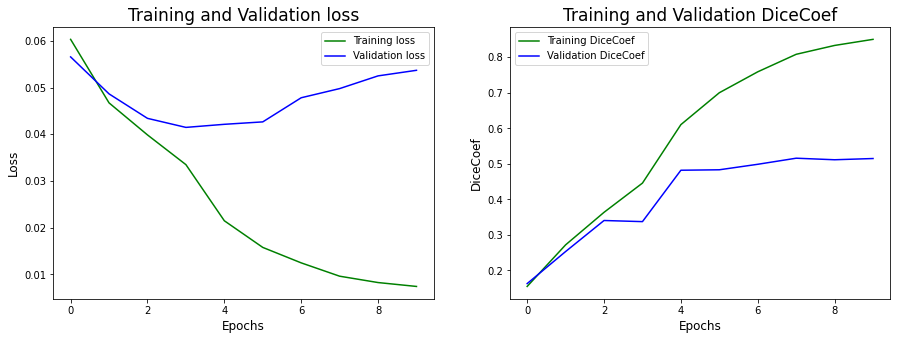

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

epochs = list(range(10))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'g', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.title('Training and Validation loss', size=17)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['dice_coef'], 'g', label='Training DiceCoef')
plt.plot(epochs, history.history['val_dice_coef'], 'b', label='Validation DiceCoef')
plt.xlabel('Epochs', size=12)
plt.ylabel('DiceCoef', size=12)
plt.title('Training and Validation DiceCoef', size=17)
plt.legend()

plt.show()

In [22]:
model.load_weights("/content/drive/MyDrive/Final project/Revised_SwinUnet.h5")
predictions = model.predict(images_train[0:1,:,:,:])

In [23]:
import matplotlib.pyplot as plt

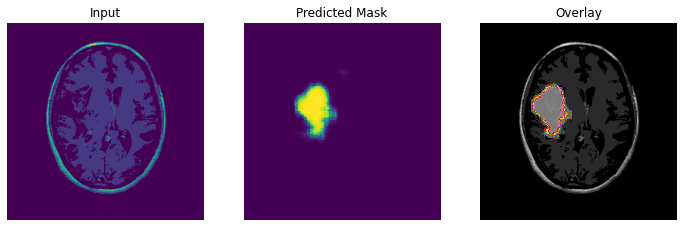

In [24]:
plt.figure(figsize=(12,10))


# pred
plt.subplot(1,3,1)
plt.title("Input")
plt.imshow(images_train[0,:,:,0])
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(predictions[0,:,:,0])
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Overlay')
plt.imshow(images_train[0,:,:,0], cmap='gray')
mask = np.ma.masked_where(predictions[0,:,:,0] <= 0.1, predictions[0,:,:,0])
plt.imshow(mask, alpha=0.8, cmap='Set1')
plt.axis('off')

plt.show()